# This CODE


is the extension of the original paper, not we have more komplex expercts learning more komplex distribtuions

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [13]:
"""
Two‑expert Log‑Normal + Pareto mixture model
• TRXExpert ‑ uses 6 transaction features
• LOBExpert ‑ uses 11 LOB features
• LatentDist ‑ softmax gate

End‑to‑end train / eval loop with ensemble of two models.
The code is self‑contained apart from the user‑specific data‑prep helpers
(read_txn_data, create_lob_dataset, preprocess_txn_data, merge_txn_and_lob).
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# ----------------------------------------------------------------------------
# 1. Deseasonalisation helper (unchanged)
# ----------------------------------------------------------------------------

def recalc(df: pd.DataFrame, train_size: float = 0.9) -> pd.DataFrame:
    df = df.copy()
    df['time'] = df['datetime'].dt.time
    train_idx = int(len(df) * train_size)
    train, rest = df.iloc[:train_idx], df.iloc[train_idx:]

    train['mean_volume'] = train.groupby('time')['total_volume'].transform('mean')
    train['deseasoned_total_volume'] = train['total_volume'] / train['mean_volume']
    train['log_deseasoned_total_volume'] = np.log(train['deseasoned_total_volume'])

    # propagate per‑minute mean to the hold‑out part
    rest = rest.merge(
        train[['time', 'mean_volume']].drop_duplicates('time'),
        on='time', how='left'
    )
    rest['mean_volume'].fillna(rest['total_volume'], inplace=True)
    rest['deseasoned_total_volume'] = rest['total_volume'] / rest['mean_volume']
    rest['log_deseasoned_total_volume'] = np.log(rest['deseasoned_total_volume'])

    return pd.concat([train, rest])

# ----------------------------------------------------------------------------
# 2. PyTorch Dataset
# ----------------------------------------------------------------------------

TRX_COLS = [
    'buy_volume', 'sell_volume', 'buy_txn', 'sell_txn',
    'volume_imbalance', 'txn_imbalance'
]
LOB_COLS = [
    'ask_volume', 'bid_volume', 'spread', 'lob_volume_imbalance',
    'ask_slope_1', 'ask_slope_5', 'ask_slope_10',
    'bid_slope_1', 'bid_slope_5', 'bid_slope_10', 'spread'
]

class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame, h: int):
        x_trx = df[TRX_COLS].to_numpy(dtype=np.float32)
        x_lob = df[LOB_COLS].to_numpy(dtype=np.float32)
        y_raw = df['log_deseasoned_total_volume'].to_numpy(dtype=np.float32)

        # z‑score target for stability
        self.y_mu = float(np.nanmean(y_raw))
        self.y_sigma = float(np.nanstd(y_raw) + 1e-8)
        y = (y_raw - self.y_mu) / self.y_sigma

        self.trx = torch.tensor(x_trx)
        self.lob = torch.tensor(x_lob)
        self.y = torch.tensor(y)
        self.h = h

    def __len__(self):
        return len(self.y) - self.h

    def __getitem__(self, idx):
        sl = slice(idx, idx + self.h)
        return (
            self.trx[sl],           # (h,6)
            self.lob[sl],           # (h,11)
            self.y[idx + self.h]    # scalar
        )

# ----------------------------------------------------------------------------
# 3. Log‑Normal + Pareto composite density
# ----------------------------------------------------------------------------

class LNP:
    def __init__(self, mu, sigma, alpha, threshold):
        self.mu = mu
        self.sigma = sigma
        self.alpha = alpha
        self.threshold = threshold
        self.weight = nn.Parameter(torch.full_like(mu[:, :1], 0.5))  # learnable mix w ∈ (0,1)

    def log_pdf(self, x, eps=1e-6):
        x = x.expand_as(self.mu)
        lognorm = -0.5 * torch.log(2 * np.pi * self.sigma ** 2) - (x - self.mu) ** 2 / (2 * self.sigma ** 2)
        pareto = torch.log(self.alpha) + self.alpha * torch.log(self.threshold) - (self.alpha + 1) * x
        ind = (x < torch.log(self.threshold)).float()
        w = torch.clamp(self.weight, 0.05, 0.95)
        log_pdf = (
            torch.log(w + eps)   + lognorm * ind +
            torch.log(1 - w + eps) + pareto * (1 - ind)
        )
        return torch.clamp(log_pdf, -100, 100)

# ----------------------------------------------------------------------------
# 4. Source‑specific experts
# ----------------------------------------------------------------------------

class _ExpertBase(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
        )
        self.mean_head = nn.Linear(32, 1)
        self.var_head = nn.Linear(32, 1)
        self.alpha_head = nn.Linear(32, 1)
        self.threshold = nn.Parameter(torch.tensor(0.0))  # global scalar per expert
        for m in (self.mean_head, self.var_head, self.alpha_head):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)

    def _stats(self, f):
        mean = self.mean_head(f)
        var = torch.clamp(torch.exp(self.var_head(f)), 1e-4, 10.0)
        alpha = torch.clamp(torch.exp(self.alpha_head(f)), 0.1, 10.0)
        thresh = torch.clamp(torch.exp(self.threshold), 0.1, 5.0)
        return mean, var, alpha, thresh

class TRXExpert(_ExpertBase):
    def __init__(self, h):
        super().__init__(h * len(TRX_COLS))

    def forward(self, trx):
        b = trx.size(0)
        x = trx.permute(0, 2, 1).reshape(b, -1)
        return self._stats(self.backbone(x))

class LOBExpert(_ExpertBase):
    def __init__(self, h):
        super().__init__(h * len(LOB_COLS))

    def forward(self, lob):
        b = lob.size(0)
        x = lob.permute(0, 2, 1).reshape(b, -1)
        return self._stats(self.backbone(x))

# ----------------------------------------------------------------------------
# 5. Gating network
# ----------------------------------------------------------------------------

class LatentDist(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(h * (len(TRX_COLS) + len(LOB_COLS)), 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, trx, lob):
        b = trx.size(0)
        x = torch.cat(
            (
                trx.permute(0, 2, 1).reshape(b, -1),
                lob.permute(0, 2, 1).reshape(b, -1)
            ), dim=1
        )
        return self.softmax(self.mlp(x))

# ----------------------------------------------------------------------------
# 6. Two‑expert mixture model
# ----------------------------------------------------------------------------

class TME(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.trx_exp = TRXExpert(h)
        self.lob_exp = LOBExpert(h)
        self.gate = LatentDist(h)

    def forward(self, trx, lob):
        m1, v1, a1, t1 = self.trx_exp(trx)
        m2, v2, a2, t2 = self.lob_exp(lob)

        # broadcast scalar thresholds to (batch,1)
        b = trx.size(0)
        t1 = t1.expand(b, 1)
        t2 = t2.expand(b, 1)

        mean = torch.cat((m1, m2), dim=1)
        var = torch.cat((v1, v2), dim=1)
        alpha = torch.cat((a1, a2), dim=1)
        threshold = torch.cat((t1, t2), dim=1)
        prob = self.gate(trx, lob)
        return mean, var, alpha, threshold, prob

# ----------------------------------------------------------------------------
# 7. Mixture log‑likelihood loss
# ----------------------------------------------------------------------------

def lnp_mixture_loss(pred, target):
    mean, var, alpha, threshold, prob = pred
    y = target.unsqueeze(1)
    lnp = LNP(mean, torch.sqrt(var), alpha, threshold)
    log_pdf = lnp.log_pdf(y)              # (batch, 2)
    log_mix = torch.sum(prob * log_pdf, dim=1)  # (batch,)
    return -log_mix.mean()

# ----------------------------------------------------------------------------
# 8. Example training loop (ensemble of 2 models)
# ----------------------------------------------------------------------------

def train_ensemble(df: pd.DataFrame, h: int = 100, epochs: int = 5):
    df = df.fillna(0).replace([np.inf, -np.inf], 0)
    train_val, test = train_test_split(df, train_size=0.9, shuffle=False)
    train, _ = train_test_split(train_val, train_size=0.9, shuffle=False)

    mu, sigma = train.iloc[:, 1:].mean(), train.iloc[:, 1:].std().replace(0, 1)
    train_ds = CustomDataset((train.iloc[:, 1:] - mu) / sigma, h)
    test_ds = CustomDataset((test.iloc[:, 1:] - mu) / sigma, h)
    train_loader = DataLoader(train_ds, 256, shuffle=False)
    test_loader = DataLoader(test_ds, 256, shuffle=False)

    models = [TME(h).double() for _ in range(2)]
    opts = [torch.optim.Adam(m.parameters(), 1e-3, weight_decay=1e-3) for m in models]

    for ep in range(1, epochs + 1):
        for mi, (m, opt) in enumerate(zip(models, opts)):
            m.train(); tot = 0.0
            for trx, lob, y in train_loader:
                trx, lob, y = trx.double(), lob.double(), y.double()
                opt.zero_grad()
                loss = lnp_mixture_loss(m(trx, lob), y)
                loss.backward()
                nn.utils.clip_grad_norm_(m.parameters(), 1.0)
                opt.step(); tot += loss.item()
            print(f"Epoch {ep} Model {mi} train_loss {tot / len(train_loader):.4f}")

        # quick test LL on first batch
        with torch.no_grad():
            trx, lob, _ = next(iter(test_loader))
            ll = sum(
                torch.logsumexp(
                    LNP(*m(trx.double(), lob.double())[:4]).log_pdf(torch.zeros_like(trx[:, :1, 0])) +
                    torch.log(m(trx.double(), lob.double())[4] + 1e-6), dim=1
                ).mean()
                for m in models
            ) / len(models)
            print(f"Ep {ep} ensemble avg loglik {ll.item():.4f}")

# ----------------------------------------------------------------------------
# (Your data‑prep code here) then call train_ensemble(df)
# ----------------------------------------------------------------------------


In [14]:
freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
train_ensemble(df)

trx Data loaded successfully.
preprocessed lob Data loaded successfully.
Epoch 1 Model 0 train_loss 2.7166
Epoch 1 Model 1 train_loss 2.7138
Ep 1 ensemble avg loglik -3.9558
Epoch 2 Model 0 train_loss 2.6263
Epoch 2 Model 1 train_loss 2.6564
Ep 2 ensemble avg loglik -3.2664
Epoch 3 Model 0 train_loss 2.5898
Epoch 3 Model 1 train_loss 2.5996
Ep 3 ensemble avg loglik -3.1283
Epoch 4 Model 0 train_loss 2.5665
Epoch 4 Model 1 train_loss 2.5833
Ep 4 ensemble avg loglik -2.5468
Epoch 5 Model 0 train_loss 2.5518
Epoch 5 Model 1 train_loss 2.5724
Ep 5 ensemble avg loglik -2.0878


In [15]:
"""
Two‑expert Log‑Normal + Pareto mixture model
------------------------------------------------
• TRXExpert – uses 6 transaction features
• LOBExpert – uses 11 order‑book features
• LatentDist – softmax gate that mixes the two experts

This single file provides:
  1. Data helpers (`recalc`, `CustomDataset`)
  2. Density definition (`LNP`)
  3. Experts, gating, and mixture model (`TME`)
  4. Training: `train_ensemble(df, h, epochs)`  →  models, test_loader, test_ds
  5. Evaluation: `evaluate_ensemble(models, test_loader, test_ds)` – prints metrics & plots

Plug in your own *data‑prep* pipeline to obtain the dataframe **df** (must contain the
columns listed in `TRX_COLS`, `LOB_COLS`, plus `datetime`, `total_volume`). Then run:

```python
models, test_loader, test_ds = train_ensemble(df, h=100, epochs=5)
evaluate_ensemble(models, test_loader, test_ds)
```
"""

# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import properscoring as ps
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)

# -----------------------------------------------------------------------------
# 1. Deseasonalisation helper (unchanged)
# -----------------------------------------------------------------------------

def recalc(df: pd.DataFrame, train_size: float = 0.9) -> pd.DataFrame:
    """Add deseasoned log‑volume columns using the first *train_size* fraction."""
    df = df.copy()
    df['time'] = df['datetime'].dt.time
    train_idx = int(len(df) * train_size)
    train, rest = df.iloc[:train_idx], df.iloc[train_idx:]

    train['mean_volume'] = train.groupby('time')['total_volume'].transform('mean')
    train['deseasoned_total_volume'] = train['total_volume'] / train['mean_volume']
    train['log_deseasoned_total_volume'] = np.log(train['deseasoned_total_volume'])

    rest = rest.merge(
        train[['time', 'mean_volume']].drop_duplicates('time'),
        on='time', how='left'
    )
    rest['mean_volume'].fillna(rest['total_volume'], inplace=True)
    rest['deseasoned_total_volume'] = rest['total_volume'] / rest['mean_volume']
    rest['log_deseasoned_total_volume'] = np.log(rest['deseasoned_total_volume'])
    return pd.concat([train, rest])

# -----------------------------------------------------------------------------
# 2. Dataset
# -----------------------------------------------------------------------------

TRX_COLS = [
    'buy_volume', 'sell_volume', 'buy_txn', 'sell_txn',
    'volume_imbalance', 'txn_imbalance'
]
LOB_COLS = [
    'ask_volume', 'bid_volume', 'spread', 'lob_volume_imbalance',
    'ask_slope_1', 'ask_slope_5', 'ask_slope_10',
    'bid_slope_1', 'bid_slope_5', 'bid_slope_10', 'spread'
]

class CustomDataset(Dataset):
    """Returns (trx[L,h,6], lob[L,h,11], target[L]) windows."""
    def __init__(self, df: pd.DataFrame, h: int):
        x_trx = df[TRX_COLS].to_numpy(np.float32)
        x_lob = df[LOB_COLS].to_numpy(np.float32)
        y_raw = df['log_deseasoned_total_volume'].to_numpy(np.float32)
        self.y_mu, self.y_sigma = float(np.nanmean(y_raw)), float(np.nanstd(y_raw) + 1e-8)
        y = (y_raw - self.y_mu) / self.y_sigma
        self.trx, self.lob, self.y = map(torch.tensor, (x_trx, x_lob, y))
        self.h = h
    def __len__(self):
        return len(self.y) - self.h
    def __getitem__(self, idx):
        sl = slice(idx, idx + self.h)
        return self.trx[sl], self.lob[sl], self.y[idx + self.h]

# -----------------------------------------------------------------------------
# 3. Log‑Normal + Pareto composite density
# -----------------------------------------------------------------------------

class LNP:
    def __init__(self, mu, sigma, alpha, threshold):
        self.mu, self.sigma, self.alpha, self.threshold = mu, sigma, alpha, threshold
        self.weight = nn.Parameter(torch.full_like(mu[:, :1], 0.5))
    def log_pdf(self, x, eps=1e-6):
        x = x.expand_as(self.mu)
        logn = -0.5 * torch.log(2 * np.pi * self.sigma ** 2) - (x - self.mu) ** 2 / (2 * self.sigma ** 2)
        pareto = torch.log(self.alpha) + self.alpha * torch.log(self.threshold) - (self.alpha + 1) * x
        ind = (x < torch.log(self.threshold)).float()
        w = torch.clamp(self.weight, 0.05, 0.95)
        lp = torch.log(w + eps) + logn * ind + torch.log(1 - w + eps) + pareto * (1 - ind)
        return lp.clamp(-100, 100)

# -----------------------------------------------------------------------------
# 4. Experts & gating
# -----------------------------------------------------------------------------

class _Expert(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.body = nn.Sequential(nn.Linear(in_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU())
        self.mean, self.var, self.alpha = nn.Linear(32,1), nn.Linear(32,1), nn.Linear(32,1)
        self.thresh = nn.Parameter(torch.tensor(0.0))
        for h in (self.mean, self.var, self.alpha): nn.init.normal_(h.weight, 0, 0.01)
    def forward(self, x):
        f = self.body(x)
        m = self.mean(f)
        v = torch.exp(self.var(f)).clamp(1e-4, 10.0)
        a = torch.exp(self.alpha(f)).clamp(0.1, 10.0)
        t = torch.exp(self.thresh).clamp(0.1, 5.0)
        return m, v, a, t

class TRXExpert(_Expert):
    def __init__(self, h): super().__init__(h * len(TRX_COLS))
    def forward(self, trx):
        b = trx.size(0)
        return super().forward(trx.permute(0,2,1).reshape(b, -1))

class LOBExpert(_Expert):
    def __init__(self, h): super().__init__(h * len(LOB_COLS))
    def forward(self, lob):
        b = lob.size(0)
        return super().forward(lob.permute(0,2,1).reshape(b, -1))

class LatentDist(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(h * (len(TRX_COLS) + len(LOB_COLS)), 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 2)
        )
        self.soft = nn.Softmax(dim=1)
    def forward(self, trx, lob):
        b = trx.size(0)
        x = torch.cat((trx.permute(0,2,1).reshape(b,-1), lob.permute(0,2,1).reshape(b,-1)), 1)
        return self.soft(self.net(x))

# -----------------------------------------------------------------------------
# 5. Mixture model & loss
# -----------------------------------------------------------------------------

class TME(nn.Module):
    def __init__(self, h):
        super().__init__(); self.trx = TRXExpert(h); self.lob = LOBExpert(h); self.gate = LatentDist(h)
    def forward(self, trx, lob):
        m1,v1,a1,t1 = self.trx(trx); m2,v2,a2,t2 = self.lob(lob)
        b = trx.size(0); t1, t2 = t1.expand(b,1), t2.expand(b,1)
        mean = torch.cat((m1,m2),1); var = torch.cat((v1,v2),1)
        alpha = torch.cat((a1,a2),1); thresh = torch.cat((t1,t2),1)
        prob = self.gate(trx, lob)
        return mean, var, alpha, thresh, prob

def lnp_mix_loss(pred, y):
    mean, var, alpha, thresh, prob = pred
    lnp = LNP(mean, var.sqrt(), alpha, thresh)
    log_pdf = lnp.log_pdf(y.unsqueeze(1))
    return -torch.sum(log_pdf * prob, 1).mean()

# -----------------------------------------------------------------------------
# 6. Training helper
# -----------------------------------------------------------------------------

def train_ensemble(df: pd.DataFrame, h: int = 100, epochs: int = 5):
    """Train two independent TME models and return them with test loader & dataset."""
    df = df.fillna(0).replace([np.inf, -np.inf], 0)
    tv, test = train_test_split(df, train_size=0.9, shuffle=False)
    train, _ = train_test_split(tv, train_size=0.9, shuffle=False)

    mu, sig = train.iloc[:, 1:].mean(), train.iloc[:, 1:].std().replace(0, 1)
    train_ds = CustomDataset((train.iloc[:, 1:] - mu) / sig, h)
    test_ds  = CustomDataset((test.iloc[:, 1:] - mu) / sig,  h)
    train_ld = DataLoader(train_ds, batch_size=256, shuffle=False)
    test_ld  = DataLoader(test_ds,  batch_size=256, shuffle=False)

    models = [TME(h).double() for _ in range(2)]
    opts   = [torch.optim.Adam(m.parameters(), 1e-3, weight_decay=1e-3) for m in models]

    for ep in range(1, epochs + 1):
        for mi, (m, opt) in enumerate(zip(models, opts)):
            m.train(); total = 0.0
            for trx, lob, y in train_ld:
                trx, lob, y = [t.double() for t in (trx, lob, y)]
                opt.zero_grad(); loss = lnp_mix_loss(m(trx, lob), y); loss.backward()
                nn.utils.clip_grad_norm_(m.parameters(), 1.0)
                opt.step(); total += loss.item()
            print(f"Epoch {ep}  Model {mi}  loss {total / len(train_ld):.4f}")
    return models, test_ld, test_ds

# -----------------------------------------------------------------------------
# 7. Prediction utilities
# -----------------------------------------------------------------------------

def _predict_single(model, trx_b, lob_b):
    mean, var, alpha, thresh, prob = model(trx_b, lob_b)
    pred = torch.sum(mean * prob, dim=1)
    second_moment = torch.sum(prob * (var + mean ** 2), dim=1)
    mix_var = second_moment - pred ** 2
    return pred, mix_var, prob, var

def predict_ensemble(models, trx_b, lob_b):
    preds, vars_ = [], []
    for m in models:
        p, v, _, _ = _predict_single(m, trx_b, lob_b)
        preds.append(p); vars_.append(v)
    return torch.stack(preds).mean(0), torch.stack(vars_).mean(0)

# -----------------------------------------------------------------------------
# 8. Evaluation routine (prints metrics and plots)
# -----------------------------------------------------------------------------

def evaluate_ensemble(models, test_loader, test_ds):
    models = [m.eval() for m in models]
    y_trues, y_preds, lowers, uppers, ll_all, comp_vars = [], [], [], [], [], []

    with torch.no_grad():
        for trx_b, lob_b, y in test_loader:
            trx_b, lob_b, y = [t.double() for t in (trx_b, lob_b, y)]
            pred, var = predict_ensemble(models, trx_b, lob_b)
            std = var.sqrt().clamp(min=1e-6)
            z = norm.ppf(0.95)
            lower, upper = pred - z * std, pred + z * std

            # log‑likelihood – average across models
            ll_batch = []
            for m in models:
                mean, v, a, t, prob = m(trx_b, lob_b)
                ll_batch.append(torch.sum(LNP(mean, v.sqrt(), a, t).log_pdf(y.unsqueeze(1)) * prob, 1))
            ll_batch = torch.stack(ll_batch).mean(0)

            # accumulate
            y_trues.append(y.cpu().numpy()); y_preds.append(pred.cpu().numpy())
            lowers.append(lower.cpu().numpy()); uppers.append(upper.cpu().numpy())
            ll_all.append(ll_batch.cpu().numpy()); comp_vars.append(var.cpu().numpy())

    y_true = np.concatenate(y_trues); y_pred = np.concatenate(y_preds)
    lower  = np.concatenate(lowers); upper = np.concatenate(uppers)
    ll_all = np.concatenate(ll_all); var   = np.concatenate(comp_vars)

    # Metrics
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nll  = -np.mean(ll_all)
    crps = np.mean([ps.crps_gaussian(y_true[i], mu=y_pred[i], sig=np.sqrt(var[i])) for i in range(len(y_true))])
    coverage = np.mean((y_true >= lower) & (y_true <= upper))

    # De‑normalise for intuitive MAPE / R²
    y_true_exp = np.exp(y_true * test_ds.y_sigma + test_ds.y_mu)
    y_pred_exp = np.exp(y_pred * test_ds.y_sigma + test_ds.y_mu)
    mape = np.mean(np.abs((y_true_exp - y_pred_exp) / y_true_exp)) * 100
    r2 = 1 - np.sum((y_true_exp - y_pred_exp) ** 2) / np.sum((y_true_exp - np.mean(y_true_exp)) ** 2)

    print(f"RMSE (norm‑log): {rmse:.4f}\nNLL: {nll:.4f}\nCRPS: {crps:.4f}\n90% coverage: {coverage:.3f}\nMAPE: {mape:.2f}%\nR²: {r2:.4f}")

    # Plots
    plt.figure();
    plt.plot(y_true, label='True'); plt.plot(y_pred, label='Pred');
    plt.fill_between(range(len(y_true)), lower, upper, alpha=0.2, label='90% PI');
    plt.legend(); plt.title('Normalised log‑volume'); plt.grid(True)

    plt.figure(); inside = ((y_true >= lower) & (y_true <= upper)).astype(int)
    plt.hist(inside, bins=[0,1,2], density=True, alpha=0.7)
    plt.xticks([0.5,1.5], ['Outside', 'Inside']); plt.title('90% Interval Coverage'); plt.grid(True)
    plt.show()


trx Data loaded successfully.
preprocessed lob Data loaded successfully.
Epoch 1  Model 0  loss 3.1516
Epoch 1  Model 1  loss 2.7407
Epoch 2  Model 0  loss 2.7222
Epoch 2  Model 1  loss 2.6575
Epoch 3  Model 0  loss 2.7650
Epoch 3  Model 1  loss 2.6029
Epoch 4  Model 0  loss 2.6951
Epoch 4  Model 1  loss 2.5767
Epoch 5  Model 0  loss 2.6684
Epoch 5  Model 1  loss 2.5634
Epoch 6  Model 0  loss 2.6792
Epoch 6  Model 1  loss 2.5546
Epoch 7  Model 0  loss 2.6558
Epoch 7  Model 1  loss 2.5484
Epoch 8  Model 0  loss 2.6681
Epoch 8  Model 1  loss 2.5459
Epoch 9  Model 0  loss 2.6745
Epoch 9  Model 1  loss 2.5569
Epoch 10  Model 0  loss 2.6385
Epoch 10  Model 1  loss 2.5769
Epoch 11  Model 0  loss 2.6936
Epoch 11  Model 1  loss 2.6097
Epoch 12  Model 0  loss 2.6715
Epoch 12  Model 1  loss 2.5300
Epoch 13  Model 0  loss 2.6657
Epoch 13  Model 1  loss 2.4895
Epoch 14  Model 0  loss 2.6710
Epoch 14  Model 1  loss 2.5289
Epoch 15  Model 0  loss 2.6277
Epoch 15  Model 1  loss 2.5181
Epoch 16  Model

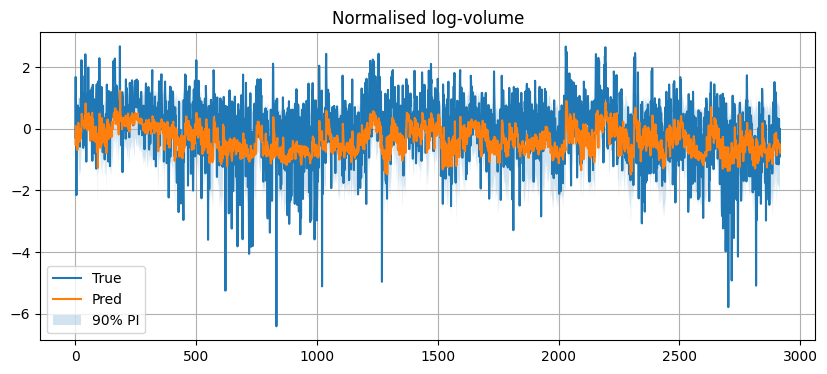

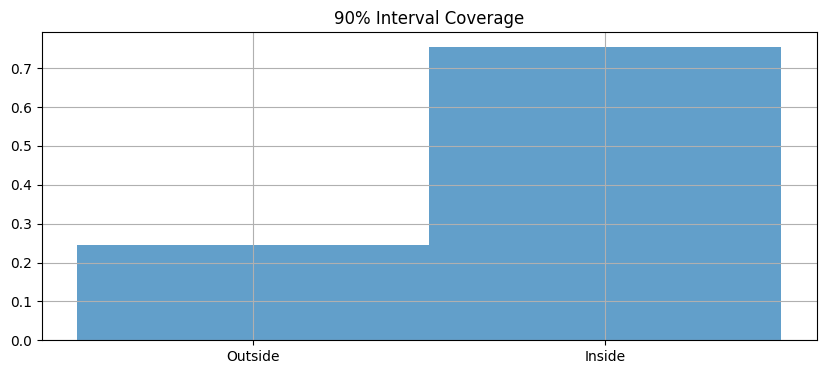

In [16]:

freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
models, test_loader, test_ds = train_ensemble(df, h=200, epochs=20)
evaluate_ensemble(models, test_loader, test_ds)

In [ ]:
"""
Two‑expert Log‑Normal + Pareto mixture model
================================================
Self‑contained script providing:

1. **Data helper**   `recalc(df)` – add deseasoned / log‑deseasoned volume.
2. **Dataset**      `CustomDataset(df, h)` – sliding windows.
3. **Density**      `LNP` composite (log‑normal ↔︎ Pareto).
4. **Model**        Two source‑specific experts + softmax gate (`TME`).
5. **Training**     `train_ensemble(df, h, epochs)` → models, loss_history, test_loader, test_ds.
6. **Plots**        `plot_learning_curves(loss_hist)` and `plot_expert_usage(models, loader)`.
7. **Evaluation**   `evaluate_ensemble(models, loader, ds)` – metrics & PI plots.

---
Typical use in a Jupyter notebook:
```python
# df = ...  # your feature DataFrame with TRX_COLS + LOB_COLS + datetime + total_volume
models, loss_hist, test_loader, test_ds = train_ensemble(df, h=100, epochs=10)
plot_learning_curves(loss_hist)
plot_expert_usage(models, test_loader)
evaluate_ensemble(models, test_loader, test_ds)
```
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import properscoring as ps
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------------------------
# 1. Deseasonalisation helper
# -----------------------------------------------------------------------------

def recalc(df: pd.DataFrame, train_size: float = 0.9) -> pd.DataFrame:
    """Add deseasoned / log‑deseasoned volume columns."""
    df = df.copy()
    df["time"] = df["datetime"].dt.time
    split = int(len(df) * train_size)
    train, rest = df.iloc[:split], df.iloc[split:]

    train["mean_volume"] = train.groupby("time")["total_volume"].transform("mean")
    train["deseasoned_total_volume"] = train["total_volume"] / train["mean_volume"]
    train["log_deseasoned_total_volume"] = np.log(train["deseasoned_total_volume"])

    rest = rest.merge(
        train[["time", "mean_volume"]].drop_duplicates("time"), on="time", how="left"
    )
    rest["mean_volume"].fillna(rest["total_volume"], inplace=True)
    rest["deseasoned_total_volume"] = rest["total_volume"] / rest["mean_volume"]
    rest["log_deseasoned_total_volume"] = np.log(rest["deseasoned_total_volume"])

    return pd.concat([train, rest])

# -----------------------------------------------------------------------------
# 2. Dataset
# -----------------------------------------------------------------------------

TRX_COLS = [
    "buy_volume", "sell_volume", "buy_txn", "sell_txn",
    "volume_imbalance", "txn_imbalance",
]
LOB_COLS = [
    "ask_volume", "bid_volume", "spread", "lob_volume_imbalance",
    "ask_slope_1", "ask_slope_5", "ask_slope_10",
    "bid_slope_1", "bid_slope_5", "bid_slope_10", "spread",
]

class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame, h: int):
        self.df = df.copy() 
        x_trx = df[TRX_COLS].to_numpy(np.float32)
        x_lob = df[LOB_COLS].to_numpy(np.float32)
        y_raw = df["log_deseasoned_total_volume"].to_numpy(np.float32)
        self.y_mu, self.y_sigma = float(np.nanmean(y_raw)), float(np.nanstd(y_raw) + 1e-8)
        y = (y_raw - self.y_mu) / self.y_sigma
        self.trx = torch.tensor(x_trx)
        self.lob = torch.tensor(x_lob)
        self.y = torch.tensor(y)
        self.h = h

    def __len__(self):
        return len(self.y) - self.h

    def __getitem__(self, idx):
        sl = slice(idx, idx + self.h)
        return self.trx[sl], self.lob[sl], self.y[idx + self.h]

# -----------------------------------------------------------------------------
# 3. Log‑Normal + Pareto composite density
# -----------------------------------------------------------------------------

class LNP(nn.Module):
    def __init__(self, mu, sigma, alpha, threshold):
        super().__init__()
        self.mu, self.sigma, self.alpha, self.threshold = mu, sigma, alpha, threshold
        self.w = nn.Parameter(torch.full_like(mu[:, :1], 0.5))

    def log_pdf(self, x, eps=1e-6):
        x = x.expand_as(self.mu)
        logn = -0.5 * torch.log(2 * np.pi * self.sigma ** 2) - (x - self.mu) ** 2 / (2 * self.sigma ** 2)
        pareto = torch.log(self.alpha) + self.alpha * torch.log(self.threshold) - (self.alpha + 1) * x
        ind = (x < torch.log(self.threshold)).float()
        w = torch.clamp(self.w, 0.05, 0.95)
        lp = torch.log(w + eps) + logn * ind + torch.log(1 - w + eps) + pareto * (1 - ind)
        return lp.clamp(-100, 100)

# -----------------------------------------------------------------------------
# 4. Experts & gating network
# -----------------------------------------------------------------------------

class _Expert(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU()
        )
        self.mean = nn.Linear(32, 1)
        self.var = nn.Linear(32, 1)
        self.alpha = nn.Linear(32, 1)
        self.t0 = nn.Parameter(torch.tensor(0.0))
        for hd in (self.mean, self.var, self.alpha):
            nn.init.normal_(hd.weight, 0.0, 0.01)

    def forward(self, x):
        f = self.body(x)
        m = self.mean(f)
        v = torch.exp(self.var(f)).clamp(1e-4, 10.0)
        a = torch.exp(self.alpha(f)).clamp(0.1, 10.0)
        t = torch.exp(self.t0).clamp(0.1, 5.0)
        return m, v, a, t

class TRXExpert(_Expert):
    def __init__(self, h):
        super().__init__(h * len(TRX_COLS))
    def forward(self, trx):
        b = trx.size(0)
        return super().forward(trx.permute(0, 2, 1).reshape(b, -1))

class LOBExpert(_Expert):
    def __init__(self, h):
        super().__init__(h * len(LOB_COLS))
    def forward(self, lob):
        b = lob.size(0)
        return super().forward(lob.permute(0, 2, 1).reshape(b, -1))

class LatentDist(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(h * (len(TRX_COLS) + len(LOB_COLS)), 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 2)
        )
        self.soft = nn.Softmax(dim=1)

    def forward(self, trx, lob):
        b = trx.size(0)
        x = torch.cat((trx.permute(0, 2, 1).reshape(b, -1), lob.permute(0, 2, 1).reshape(b, -1)), 1)
        return self.soft(self.net(x))

# -----------------------------------------------------------------------------
# 5. Mixture model & loss
# -----------------------------------------------------------------------------

class TME(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.trx_exp = TRXExpert(h)
        self.lob_exp = LOBExpert(h)
        self.gate = LatentDist(h)

    def forward(self, trx, lob):
        m1, v1, a1, t1 = self.trx_exp(trx)
        m2, v2, a2, t2 = self.lob_exp(lob)
        b = trx.size(0)
        t1, t2 = t1.expand(b, 1), t2.expand(b, 1)
        mean = torch.cat((m1, m2), 1)
        var = torch.cat((v1, v2), 1)
        alpha = torch.cat((a1, a2), 1)
        thresh = torch.cat((t1, t2), 1)
        prob = self.gate(trx, lob)
        return mean, var, alpha, thresh, prob

def lnp_mix_loss(pred, y):
    mean, var, alpha, thresh, prob = pred
    lp = LNP(mean, var.sqrt(), alpha, thresh).log_pdf(y.unsqueeze(1))
    return -torch.sum(lp * prob, 1).mean()

# -----------------------------------------------------------------------------
# 6. Training helper (records train loss)
# -----------------------------------------------------------------------------

def train_ensemble(df: pd.DataFrame, h: int = 100, epochs: int = 10):
    df = df.fillna(0).replace([np.inf, -np.inf], 0)
    tv, test = train_test_split(df, train_size=0.9, shuffle=False)
    train, _ = train_test_split(tv, train_size=0.9, shuffle=False)

    mu, sig = train.iloc[:, 1:].mean(), train.iloc[:, 1:].std().replace(0, 1)
    train_ds = CustomDataset((train.iloc[:, 1:] - mu) / sig, h)
    test_ds = CustomDataset((test.iloc[:, 1:] - mu) / sig, h)
    train_ld = DataLoader(train_ds, 256, shuffle=False)
    test_ld = DataLoader(test_ds, 256, shuffle=False)

    models = [TME(h).double().to(DEVICE) for _ in range(2)]
    opts = [torch.optim.Adam(m.parameters(), lr=1e-3) for m in models]
    loss_hist = [[] for _ in models]

    for ep in range(1, epochs + 1):
        for mi, (m, opt) in enumerate(zip(models, opts)):
            m.train(); tot = 0.0
            for trx, lob, y in train_ld:
                trx, lob, y = [t.double().to(DEVICE) for t in (trx, lob, y)]
                opt.zero_grad(); loss = lnp_mix_loss(m(trx, lob), y); loss.backward(); opt.step(); tot += loss.item()
            loss_hist[mi].append(tot / len(train_ld))
            print(f"Epoch {ep} Model {mi} loss {loss_hist[mi][-1]:.4f}")
    return models, loss_hist, test_ld, test_ds

# -----------------------------------------------------------------------------
# 7. Prediction helpers
# -----------------------------------------------------------------------------

def _predict_single(model, trx_b, lob_b):
    mean, var, alpha, thresh, prob = model(trx_b, lob_b)
    pred = torch.sum(mean * prob, 1)
    second = torch.sum(prob * (var + mean ** 2), 1)
    mix_var = second - pred ** 2
    return pred, mix_var, prob

def predict_ensemble(models, trx_b, lob_b):
    preds, vars_ = [], []
    for m in models:
        p, v, _ = _predict_single(m, trx_b, lob_b)
        preds.append(p); vars_.append(v)
    return torch.stack(preds).mean(0), torch.stack(vars_).mean(0)

# -----------------------------------------------------------------------------
# 8. Plots: learning curves & expert usage
# -----------------------------------------------------------------------------

def plot_learning_curves(loss_hist):
    plt.figure();
    for i, lh in enumerate(loss_hist):
        plt.plot(range(1, len(lh) + 1), lh, label=f"Model {i}")
    plt.xlabel("Epoch"); plt.ylabel("Train loss"); plt.title("Learning curves"); plt.grid(True); plt.legend(); plt.show()

def plot_expert_usage(models, loader):
    """Bar chart of **average** gate probability per expert (aggregate metric)."""
    usages = []
    with torch.no_grad():
        for m in models:
            probs = []
            for trx, lob, _ in loader:
                trx, lob = [t.double().to(DEVICE) for t in (trx, lob)]
                probs.append(m.gate(trx, lob).cpu().numpy())
            usages.append(np.concatenate(probs).mean(0))
    usages = np.array(usages)
    x = np.arange(len(models))
    plt.figure()
    plt.bar(x - 0.15, usages[:, 0], 0.3, label="Expert 0 (TRX)")
    plt.bar(x + 0.15, usages[:, 1], 0.3, label="Expert 1 (LOB)")
    plt.xticks(x, [f"M{i}" for i in x]); plt.ylim(0, 1)
    plt.ylabel("Avg gate prob"); plt.title("Expert usage – average"); plt.grid(axis="y"); plt.legend(); plt.show()

# --- NEW: detailed gate‑probability curve ------------------------------------

def plot_gate_probability_series(models, loader, max_points: int = 1000):
    """Plot per‑sample gating probabilities (no averaging). Shows first `max_points` samples.

    One line per expert × model → up to *2 × n_models* curves.
    """
    curves = []  # list[(model_id, expert_id, probs)]
    with torch.no_grad():
        for mi, m in enumerate(models):
            all_probs = []
            for trx, lob, _ in loader:
                trx, lob = [t.double().to(DEVICE) for t in (trx, lob)]
                all_probs.append(m.gate(trx, lob).cpu().numpy())
            probs = np.concatenate(all_probs)[:max_points]  # shape (L, 2)
            curves.append((mi, 0, probs[:, 0]))
            curves.append((mi, 1, probs[:, 1]))

    plt.figure(figsize=(10, 4))
    for mi, ei, series in curves:
        plt.plot(series, label=f"M{mi}‑E{ei}", alpha=0.8)
    plt.xlabel("Sample index"); plt.ylabel("Gate probability");
    plt.title("Per‑sample gating probabilities (first " + str(max_points) + " samples)");
    plt.ylim(0, 1); plt.grid(True); plt.legend(ncol=len(models)); plt.show()

# -----------------------------------------------------------------------------
# 9. Evaluation routine
# -----------------------------------------------------------------------------

def evaluate_ensemble(models, loader, ds):
    for m in models: m.eval()
    y_true_l, y_pred_l, low_l, up_l, ll_l, var_l = [], [], [], [], [], []
    with torch.no_grad():
        for trx, lob, y in loader:
            trx, lob, y = [t.double().to(DEVICE) for t in (trx, lob, y)]
            pred, var = predict_ensemble(models, trx, lob)
            std = var.sqrt().clamp(min=1e-6)
            z = norm.ppf(0.95); lower, upper = pred - z * std, pred + z * std
            # log‑likelihood avg across models
            ll_batch = []
            for m in models:
                mean, v, a, t, prob = m(trx, lob)
                ll = torch.sum(LNP(mean, v.sqrt(), a, t).log_pdf(y.unsqueeze(1)) * prob, 1)
                ll_batch.append(ll)
            ll = torch.stack(ll_batch).mean(0)

            y_true_l.append(y.cpu().numpy()); y_pred_l.append(pred.cpu().numpy())
            low_l.append(lower.cpu().numpy()); up_l.append(upper.cpu().numpy())
            ll_l.append(ll.cpu().numpy()); var_l.append(var.cpu().numpy())

    y_true = np.concatenate(y_true_l); y_pred = np.concatenate(y_pred_l)
    low = np.concatenate(low_l); up = np.concatenate(up_l)
    ll = np.concatenate(ll_l); var = np.concatenate(var_l)

 

    # Undo log and standardization
    y_true_deseasoned = np.exp(y_true * ds.y_sigma + ds.y_mu)
    y_pred_deseasoned = np.exp(y_pred * ds.y_sigma + ds.y_mu)

    # Multiply back the seasonal component (mean_volume per time)
    mean_vol = ds.df["mean_volume"].iloc[ds.h:].to_numpy()
    y_true_total = y_true_deseasoned * mean_vol
    y_pred_total = y_pred_deseasoned * mean_vol


    mape = np.mean(np.abs((y_true_total - y_pred_total) / y_true_total)) * 100
    r2 = 1 - np.sum((y_true_total - y_pred_total) ** 2) / np.sum((y_true_total - y_true_total.mean()) ** 2)
    rmse = np.sqrt(mean_squared_error(y_true_total, y_pred))
    nll = -ll.mean()
    crps = np.mean([ps.crps_gaussian(y_true_total[i], mu=y_pred[i], sig=np.sqrt(var[i])) for i in range(len(y_true_total))])
    coverage = np.mean((y_true_total >= low) & (y_true_total <= up))

    print(f"RMSE: {rmse:.4f}")
    print(f"NLL: {nll:.4f}")
    print(f"CRPS: {crps:.4f}")
    print(f"Coverage 90%: {coverage:.3f}")
    print(f"MAPE: {mape:.2f}")
    print(f"R²: {r2:.4f}")

    plt.figure(); plt.plot(y_true_total, label="True"); plt.plot(y_pred, label="Pred")
    plt.fill_between(range(len(y_true_total)), low, up, alpha=0.2, label="90% PI")
    plt.title("Normalised log‑volume"); plt.legend(); plt.grid(True)

    plt.figure(); inside = ((y_true_total >= low) & (y_true_total <= up)).astype(int)
    plt.hist(inside, bins=[0, 1, 2], density=True); plt.xticks([0.5, 1.5], ["Out", "In"])
    plt.title("PI coverage"); plt.grid(True); plt.show()


In [18]:

freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


Epoch 1 Model 0 loss 2.7189
Epoch 1 Model 1 loss 2.7119
Epoch 2 Model 0 loss 2.6763
Epoch 2 Model 1 loss 2.6247
Epoch 3 Model 0 loss 2.6626
Epoch 3 Model 1 loss 2.6338
Epoch 4 Model 0 loss 2.6449
Epoch 4 Model 1 loss 2.5716
Epoch 5 Model 0 loss 2.6258
Epoch 5 Model 1 loss 2.5526
Epoch 6 Model 0 loss 2.6200
Epoch 6 Model 1 loss 2.5379
Epoch 7 Model 0 loss 2.6179
Epoch 7 Model 1 loss 2.5221
Epoch 8 Model 0 loss 2.6302
Epoch 8 Model 1 loss 2.5119
Epoch 9 Model 0 loss 2.6165
Epoch 9 Model 1 loss 2.4991
Epoch 10 Model 0 loss 2.6031
Epoch 10 Model 1 loss 2.4943


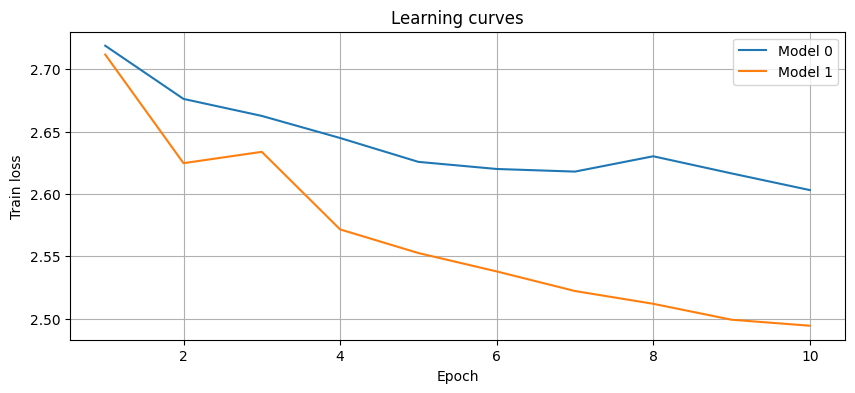

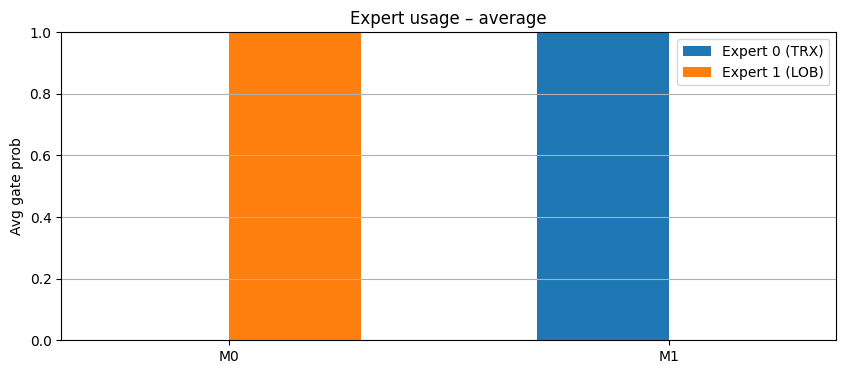

RMSE: 1.6377
NLL: 2.6775
CRPS: 0.7576
Coverage 90%: 0.822
MAPE: 129.96
R²: 0.3400


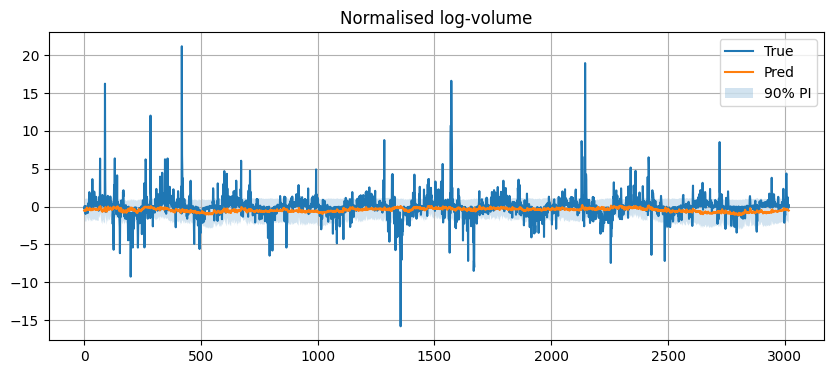

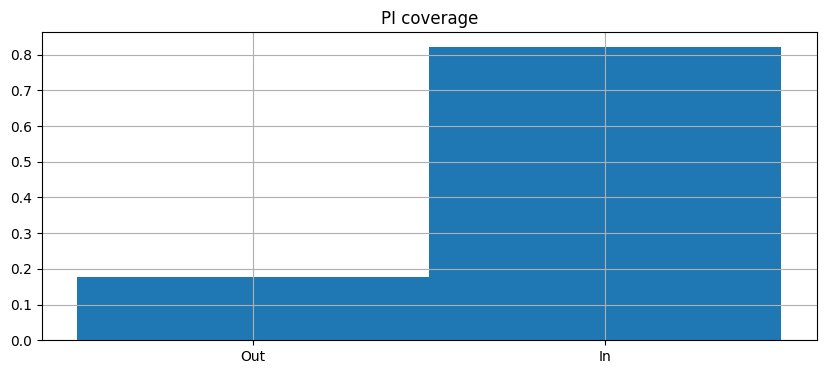

In [25]:
models, loss_hist, test_loader, test_ds = train_ensemble(df, h=100, epochs=10)
plot_learning_curves(loss_hist)
plot_expert_usage(models, test_loader)
evaluate_ensemble(models, test_loader, test_ds)